In [ ]:
import os
import json
from datasets import Dataset
from ragas.metrics import faithfulness, answer_relevancy, context_precision, context_recall
from ragas import evaluate
from langchain_huggingface import HuggingFaceEmbeddings
import torch 
from dotenv import load_dotenv

load_dotenv("../.env", override=True)

# Configuración OpenRouter
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_KEY")
os.environ["OPENAI_BASE_URL"] = "https://openrouter.ai/api/v1"

device = "cuda" if torch.cuda.is_available() else "cpu"

# Embeddings
embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-mpnet-base-v2", 
    model_kwargs={'device': device}
)

def evaluar_y_guardar(path_json, nombre_modelo, path_csv):
    with open(path_json, "r", encoding="utf-8") as f:
        data = json.load(f)
    
    dataset = Dataset.from_list([
        {
            "question": item["question"],
            "contexts": item["contexts"],
            "answer": item["answer"],
            "ground_truth": item["ground_truth"]
        }
        for item in data
    ])
    
    print(f"\nEvaluando: {nombre_modelo}")
    result = evaluate(
        dataset=dataset,
        metrics=[faithfulness, answer_relevancy, context_precision, context_recall],
        embeddings=embeddings
    )
    
    
    df = result.to_pandas()
    df.to_csv(path_csv, index=False)
    print(f"Guardado en {path_csv}")

evaluar_y_guardar("../groq_advanced_ds.json", "llama Advanced", "../resultados/reportes_csv/groq_advanced.csv")
evaluar_y_guardar("../groq_ds.json", "llama Basic", "../resultados/reportes_csv/groq_basic.csv")
evaluar_y_guardar("../qwen_advanced_ds.json", "Qwen Advanced", "../resultados/reportes_csv/qwen_advanced.csv")
evaluar_y_guardar("../qwen_ds.json", "Qwen Basic", "../resultados/reportes_csv/qwen_basic.csv")
evaluar_y_guardar("../gemini_advanced_ds.json", "Gemini Advanced", "../resultados/reportes_csv/gemini_advanced.csv")
evaluar_y_guardar("../gemini_ds.json", "Gemini Basic", "../resultados/reportes_csv/gemini_basic.csv")

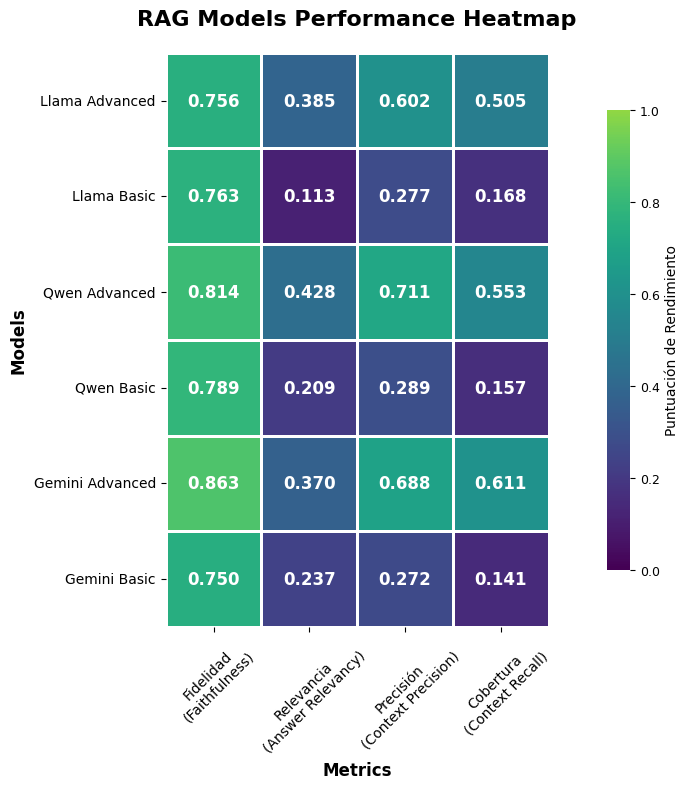

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def create_professional_heatmap():
    """Crear solo el mapa de calor profesional para RAG"""
    
    # Cargar todos los modelos
    models = {
        'Llama Advanced': pd.read_csv("../resultados/reportes_csv/groq_advanced.csv"),
        'Llama Basic': pd.read_csv("../resultados/reportes_csv/groq_basic.csv"),
        'Qwen Advanced': pd.read_csv("../resultados/reportes_csv/qwen_advanced.csv"),
        'Qwen Basic': pd.read_csv("../resultados/reportes_csv/qwen_basic.csv"),
        'Gemini Advanced': pd.read_csv("../resultados/reportes_csv/gemini_advanced.csv"),
        'Gemini Basic': pd.read_csv("../resultados/reportes_csv/gemini_basic.csv")
    }
    
    metrics = ["faithfulness", "answer_relevancy", "context_precision", "context_recall"]
    
    # Preparar datos para el heatmap
    heatmap_data = []
    model_names = []
    
    for name, df in models.items():
        model_names.append(name)
        heatmap_data.append([df[metric].mean() for metric in metrics])
    
    # Crear DataFrame para el heatmap
    heatmap_df = pd.DataFrame(
        heatmap_data, 
        columns=['Fidelidad\n(Faithfulness)', 'Relevancia\n(Answer Relevancy)', 
                'Precisión\n(Context Precision)', 'Cobertura\n(Context Recall)'],
        index=model_names
    )
    
    # Configurar el estilo
    plt.figure(figsize=(12, 8))
    plt.style.use('default')
    
    # Crear el heatmap con la paleta original
    ax = sns.heatmap(
        heatmap_df, 
        annot=True, 
        cmap='viridis', 
        center=0.6,
        square=True, 
        linewidths=2, 
        cbar_kws={
            "shrink": .8, 
            "label": "Puntuación de Rendimiento"
        },
        fmt='.3f', 
        annot_kws={
            'fontsize': 12, 
            'fontweight': 'bold',
            'color': 'white'
        },
        vmin=0, 
        vmax=1
    )
    
    # Personalizar el estilo de forma más simple
    ax.set_title('RAG Models Performance Heatmap', 
                fontsize=16, fontweight='bold', pad=20)
    
    # Etiquetas más simples
    ax.set_xlabel('Metrics', fontsize=12, fontweight='bold')
    ax.set_ylabel('Models', fontsize=12, fontweight='bold')
    
    # Rotar etiquetas para evitar solapamiento
    ax.tick_params(axis='x', rotation=45, labelsize=10)
    ax.tick_params(axis='y', rotation=0, labelsize=10)
    
    # Mejorar la barra de color
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=9)
    
    # Fondo limpio y layout
    plt.tight_layout()
    
    # IMPORTANTE: Guardar ANTES de mostrar
    plt.savefig('heatmap_rag_models.png', dpi=300, bbox_inches='tight', 
                facecolor='white', edgecolor='none')
    
    # Mostrar el gráfico DESPUÉS de guardar
    plt.show()
    
    return heatmap_df

# Crear el heatmap
heatmap_data = create_professional_heatmap()



## 📊 Evaluación comparativa de modelos/Configuraciones RAG

#### Configuración Advanced
| Modelo | Faithfulness  | Answer Relevancy  | Context Precision  | Context Recall |
|--------|:--------------:|:------------------:|:-------------------:|:---------------:|
| **Llama Advanced** | 0.756 | 0.385 | 0.602 | 0.505 |
| **Qwen Advanced** | **0.814** ⭐ | **0.428** ⭐ | **0.711** ⭐ | **0.553** ⭐ |
| **Gemini Advanced** | **0.863** ⭐ | 0.370 | 0.688 | **0.611** ⭐ |

#### Configuración Basic
| Modelo | Faithfulness  | Answer Relevancy  | Context Precision  | Context Recall |
|--------|:--------------:|:------------------:|:-------------------:|:---------------:|
| **Llama Basic** | **0.763** ⭐ | 0.113 | 0.277 | 0.168 |
| **Qwen Basic** | 0.789 | **0.209** ⭐ | **0.289** ⭐ | **0.157** ⭐ |
| **Gemini Basic** | 0.750 | **0.237** ⭐ | 0.272 | 0.141 |

---
### Mejores Rendimientos por Métrica:
- **Faithfulness**: Gemini Advanced - 0.863
- **Answer Relevancy**: Qwen Advanced - 0.428  
- **Context Precision**: Qwen Advanced - 0.711
- **Context Recall**: Gemini Advanced - 0.611


